# Solutions for Lab Sheet 7 (COM3502-4502-6502 Speech Processing)

This lab sheet (solution) is part of the lecture COM[3502](http://www.dcs.shef.ac.uk/intranet/teaching/public/modules/level3/com3502.html "Open web page for COM3502 module")-[4502](http://www.dcs.shef.ac.uk/intranet/teaching/public/modules/level4/com4502.html "Open web page for COM4502 module")-[6502](http://www.dcs.shef.ac.uk/intranet/teaching/public/modules/msc/com6502.html "Open web page for COM4502 module") Speech Processing at the [University of Sheffield](https://www.sheffield.ac.uk/ "Open web page of The University of Sheffield"), Dept. of [Computer Science](https://www.sheffield.ac.uk/dcs "Open web page of Department of Computer Science, University of Sheffield").

It is probably easiest to open this Jupyter Notebook with [Google Colab](https://colab.research.google.com/notebooks/intro.ipynb#recent=true "Open in Google Colab") by clicking on the icon on the right, but this notebook is displayed best when opened locally using Jupyter Notebook (e.g. as part of the [Anaconda](https://www.anaconda.com/) distribution which is already installed on the lab computers). <a href="https://colab.research.google.com/github/sap-shef/SpeechProcesssingLab/blob/main/Lab-Sheet-Solutions/Lab-Sheet-7-Solution.ipynb"><img align="right" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open Notebook in Google Colab" title="Open and Execute the Notebook directly in Google Colaboratory"></a>

<div class="alert alert-block alert-success" id='ILOs'>
<strong>Intended Learning Objectives (ILOs):</strong><br>
    
After completing this Jupyter Notenook you should
    
<ul>
<li>further familiarise with correlation and the autocorrelation sequence.
</li>
<li>be able to use the autocorrelation sequence to estimate the fundamental freuency / pitch frequency of a signal
</li>
<li>be able to generate a glottal impulse
</li>
<li>understand basic use of the <code>Python</code> libraries 
    <ul>
    <li><a href="https://numpy.org/doc/stable/index.html"><code>Numpy</code></a> commands 
        <a href="https://numpy.org/doc/stable/reference/generated/numpy.correlate.html"><code>correlate()</code></a>,
        <a href="https://numpy.org/doc/stable/reference/generated/numpy.floor.html"><code>floor()</code></a>,
        <a href="https://numpy.org/doc/stable/reference/generated/numpy.ceil.html"><code>ceil()</code></a>,
        <a href="https://numpy.org/doc/stable/reference/generated/numpy.round.html"><code>round()</code></a>,
        <a href="https://numpy.org/doc/stable/reference/generated/numpy.arange.html"><code>arange()</code></a>,
        etc.
    </li>
    <li><a href="https://matplotlib.org/"><code>Matplotlib</code></a> for graphical output (like 
        <a href="https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.gca.html"><code>gca()</code></a>, 
        <a href="https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.twiny.html"><code>twiny()</code></a>, 
        <a href="https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.get_xticks.html"><code>get_xticks()</code></a>, 
        <a href="https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.set_xticks.html"><code>set_xticks()</code></a>, 
        <a href="https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.get_xbound.html"><code>get_xbound()</code></a>, 
        <a href="https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.set_xbound.html"><code>set_xbound()</code></a>,
        <a href="https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.set_xticklabels.html"><code>set_xticklabels()</code></a>,
        <a href="https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.set_xlabel.html"><code>set_xlabel()</code></a>,
        etc.)
    </li>
    </ul>
</li>
</ul>
</div>

In [1]:
# Let's do the ususal necessary and nice-to-have imports
%matplotlib notebook
import matplotlib.pyplot as plt     # plotting
import seaborn as sns; sns.set()    # styling ((un-)comment if you want)
import numpy as np                  # math

# imports we need in addition for this lab sheet
from IPython import display as ipd  # to listen to audio
import scipy.signal as sig          # for PSD calculation
import soundfile as sf              # to load WAVE files

In a [Lab-Sheet 6](./Lab-Sheet-6-Solution.ipynb) we created a periodically repeated noise signal of length $𝐿=8000$ samples by concatenating $𝐿/𝑃$ repetitions of a random signal of length $𝑃=100$ sampleswhich we will re-use here for further analysis.

<IPython.core.display.Javascript object>


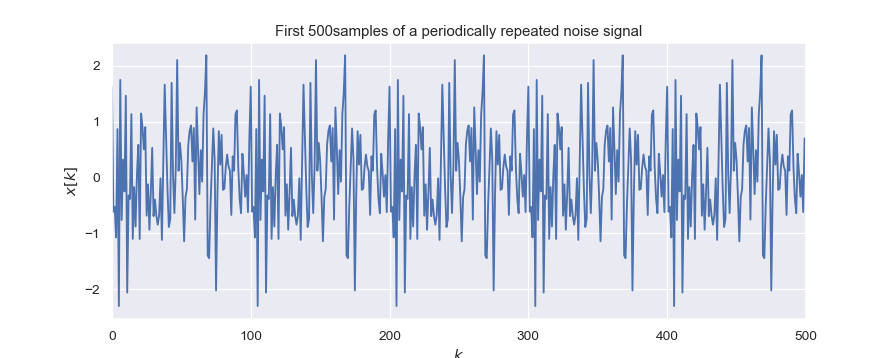

In [2]:
L = 8000 # total length of signal
P = 100  # period

K = 250  # analysis length

# generate periodic random signal
np.random.seed(1) # this ensures that always the same "random" signal is generated
x0 = np.random.normal(size=P)
x  = np.tile(x0, L//P)

plt.figure(figsize=(10, 4))
#plt.stem(x[:2*K], basefmt='C0:', use_line_collection=True)
plt.plot(x[:2*K])
plt.xlim(0, 2*K)
plt.xlabel('$k$')
plt.ylabel('$x[k]$')
plt.title('First '+str(2*K)+'samples of a periodically repeated noise signal')
plt.grid(True)

# listen to the sound file
ipd.Audio(x, rate=8000)

## Autocorrelation Sequence, a.k.a. Autocorrelation Function

In a [previous notebook (Lab-Sheet 3)](./Lab-Sheet-3-Solution.ipynb) we calculated the [correlation](https://en.wikipedia.org/wiki/Correlation_and_dependence) and the correlation coefficient $\hat{r}_{xx}$ as a scalar quantity indicating how correlated two signals (of the same length) are. Correlation in general is a statistical measure for the dependencies between random processes or between the samples of one random process. As a result we are interested in the (auto-)correlation between $x[k]$ and $x[k-\kappa]$, the time-shifted version of $x[k]$. This information can be analysed by the [auto-correlation function](https://en.wikipedia.org/wiki/Autocorrelation) (ACF) which characterizes the temporal dependencies within one random signal $x[k]$. We will use the ACF for estimation of the fundamental (pitch) frequency of a speech excitation signal in the later part of this notebook.

### Background Theory and Definition

For a continuous-amplitude, real-valued random signal $x[k]$ the auto-covariance $c_{xx}[k_1, k_2]$ and the ACF $r_{xx}[k_1, k_2]$ are defined as<sup>[[MW1]](https://mathworld.wolfram.com/StatisticalCorrelation.html)</sup>

\begin{eqnarray}
\label{eq:Autocovariance}
c_{xx}[k_1, k_2] &=& \mathrm{E}\{ (x[k_1]-\mu) \cdot (x[k_2]-\mu) \} \\
r_{xx}[k_1, k_2] &=& \frac{\mathrm{E}\{ x[k_1] \cdot x[k_2] \}}{\sigma_x \sigma_y}. \tag{1}
\label{eq:AutocorrelationDesinition}
\end{eqnarray}

with $\mathrm{E}\{ \cdot  \}$ being the expectation of the signal at two different time-instants $k_1$ and $k_2$:

If we assume [wide-sense stationarity](stationary_ergodic.ipynb#Wide-Sense-Stationary-Random-Processes) (WSS) the ACF does only depend on the time difference $\kappa = k_1 - k_2$ between the considered sample indices and standard deviations of the signals being ${\sigma}_x={\sigma}_y=1$, we can simplify (\ref{eq:AutocorrelationDesinition}) to

\begin{equation}
r_{xx}[\kappa] = \mathrm{E}\{x[k] \cdot x[k-\kappa] \}, \tag{2}
\label{eq:AutocorrelationDesinitionStationary}
\end{equation}

where $\kappa$ is commonly chosen as sample index instead of $k$ to indicate that it denotes a time shift / lag. The ACF quantifies the similarity of a signal with a shifted version of itself. It has high (positive / negative) values for high similarity and low (positive / negative) values for low similarity which is in line with our findings from [Lab-Sheet 3](./Lab-Sheet-3-Solution.ipynb).


### A Correlation Estimator

Since the definitions in (\ref{eq:AutocorrelationDesinition}) and (\ref{eq:AutocorrelationDesinitionStationary}) depend on the expectation operator $\mathrm{E}\{ \cdot \}$, which can only be estimated rather than calculated, we are interested in such an estimator for $r_{xx}[\kappa]$. Thus, we define the *autocorrelation function estimate* at a time shift $\kappa$ of the signal $x[k]$ of length $L$ as

\begin{equation}
\hat{r}_{xx}[\kappa] = \frac{1}{L} \sum_{k=1}^{L-1}x[k]x[k+\kappa]  \tag{3}
\label{eq:AutocorrelationEstFullSum}
\end{equation}

for all values of $\kappa$ from $0$ to $L-1$, i.e., for each $\kappa$ we correlate the non-shifted signal with a signal shifted by $\kappa$ samples. Note that the hat $\hat\cdot$ indicates that $\hat{r}_{xx}[\kappa]$ is the estimate of $r_{xx}[\kappa]$.

Note that in numerical implementations (e.g. MATLAB, Python with `mode='full'`), the computed ACF returns a vector of length $2 L - 1$ containing values from negative $\kappa$s to positive $\kappa$s. For an interpretation with respect to the actual time lag $\kappa$, $L-1$ must be subtracted from these indices. More previsely, the autocorrelation is symmetric regarding $\kappa=0$ for real-valued signals.

Further note that $\frac{1}{L}$-averaging in (\ref{eq:AutocorrelationEstFullSum}) yields a [biased estimator](https://en.wikipedia.org/wiki/Bias_of_an_estimator) of the ACF, which consistently should be denoted with $\hat{r}_{xx,\mathrm{biased}}[\kappa]$. The bias is in form of a triangle and which can be removed by adapting the normalisation. The unbiased estimator of the ACF is given as
$$\hat{r}_{xx,\mathrm{unbiased}}[\kappa] = \frac{1}{L-|\kappa|}\sum_{k=0}^{L-1} x[k] \cdot x[k-\kappa].$$

The following code will visualise the ACF estimate according to (\ref{eq:AutocorrelationEstFullSum}).

Length of the signal x is L=8000
Length of the ACF is : 15999
[ 1.41730637e-04 -1.79265134e-04  1.01781303e-05 ...  1.01781303e-05
 -1.79265134e-04  1.41730637e-04]


<IPython.core.display.Javascript object>


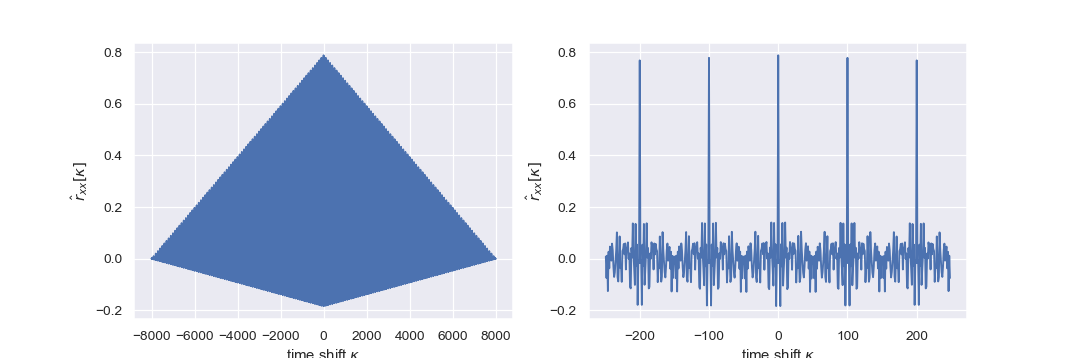

In [3]:
K = 250  # upper/lower limit for lag in ACF

# compute the ACF
acf = 1/len(x) * np.correlate(x, x, mode='full')

print('Length of the signal x is L=' + str(len(x)))
print('Length of the ACF is : ' + str(len(acf)))
print(acf)

# plot ACF over full length
kappa = np.arange(-(L-1), L)
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(kappa,acf)
plt.xlabel('time shift $\kappa$')
plt.ylabel('$\hat{r}_{xx}[\kappa]$')

# truncate ACF and plot area of interest around the center
acf_center=(len(x)-1)
kappa = np.arange(-(L-1), L)
plt.subplot(1,2,2)
plt.plot(kappa[acf_center-(K-1):acf_center+(K-1)],
         acf[acf_center-(K-1):acf_center+(K-1)])
plt.xlabel('time shift $\kappa$')
plt.ylabel('$\hat{r}_{xx}[\kappa]$')
None # suppress last output

The two panels in the figure above both show the same function, i.e. the ACF, but for differnt ranges of $\kappa$. The plot in the right panel is of limited use since the fine structure of the ACF is not visible. However, it showes the bias of the estimate in form of a tiangular general shaping. The right panel shows the ACF zommed into the area of interest i.e for $-K \leq \kappa \leq K$ with $K=250$.

The prpminent peak in the centre (at $\kappa=0$) indicates that the signal is highly correlated with itself if it is not shifted (which is true for all possible signals). More interesting are the other peaks which have a distance of $100$ samples each. This means that the signal has high similarity with itself for each shift of $100$ samples (which is how we designed our periodic noise signal).

The following code reproduced the ACF $\hat{r}_{xx}[\kappa]$ in larger scale and with the cutout of the original signal $x[k]$ to visualise that the periodicity is much easier to determin in the ACF $\hat{r}_{xx}[\kappa]$ than in the time domain signal $x[k]$.

-249 <= kappa <= 249


<IPython.core.display.Javascript object>


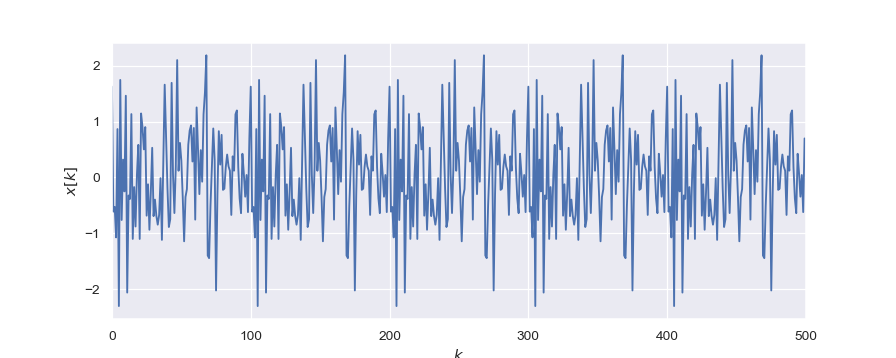

<IPython.core.display.Javascript object>


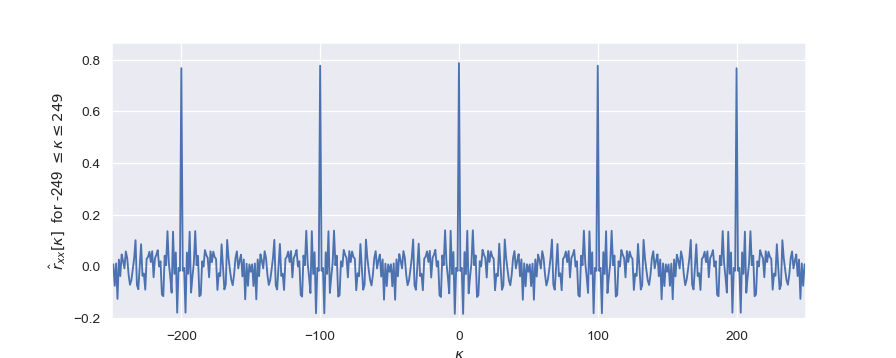

In [4]:
# compute and truncate ACF
acf = 1/len(x) * np.correlate(x, x, mode='full')
acf = acf[(len(x)-1)-(K-1):(len(x)-1)+K]
kappa = np.arange(-(K-1), K)
print(str(np.min(kappa)) + ' <= kappa <= ' + str(np.max(kappa)) )

# plot signal and its ACF
plt.figure(figsize=(10, 4))
#plt.stem(x[:2*K], basefmt='C0:', use_line_collection=True)
plt.plot(x[:2*K])
plt.xlim(0, 2*K)
plt.xlabel('$k$')
plt.ylabel('$x[k]$')
plt.grid(True)

plt.figure(figsize=(10, 4))
#plt.stem(kappa, acf, basefmt='C0:', use_line_collection=True)
plt.plot(kappa, acf)
plt.xlabel('$\kappa$')
plt.ylabel('$\hat{r}_{xx}[\kappa]$  for ' + str(np.min(kappa)) + ' $\leq \kappa \leq ' + str(np.max(kappa)) + '$')
plt.axis([-K, K, 1.1*min(acf), 1.1*max(acf)])
plt.grid(True)

# Autocorrelation of Voiced Sound Segments - Task 4

Since we analysed that the ACF analyses periodicity in a signal and also the period of this periodicity we use the ACF in the following to determine the periodicity within a speech signal segment $s[k]$. The following code loads a speech signal segment $s[k]$ from the Internet and into a Python variable `s`. 

In [5]:
# download speech and noise example files
s_file_name = 'voiced_unvoiced_e.wav'
!curl https://staffwww.dcs.shef.ac.uk/people/S.Goetze/sound/{s_file_name} -o {s_file_name} 

# load speech wave into variable
s, fs = sf.read(s_file_name)

print('File "' + s_file_name + '" loaded. Its sampling rate is ' + str(fs) + ' Hz.')

# listen to the sound file (if you want)
ipd.Audio(s, rate=fs)

File "voiced_unvoiced_e.wav" loaded. Its sampling rate is 44100 Hz.


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 77100  100 77100    0     0   167k      0 --:--:-- --:--:-- --:--:--  167k


We visualise the beginning of the speech sound signal $s[k]$ which is a sustained vovel  in the following. We see the beginning of a periodic segment. The lower panel of the following plot calculate the ACF $\hat{r}_{ss}[\kappa]$.

-999 <= kappa <= 999


<IPython.core.display.Javascript object>


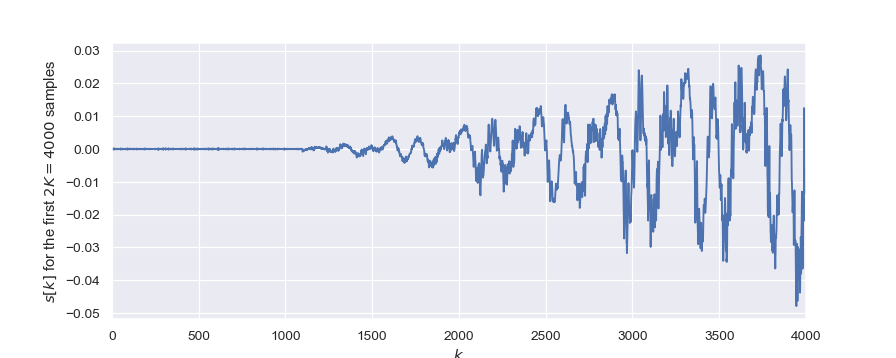

<IPython.core.display.Javascript object>


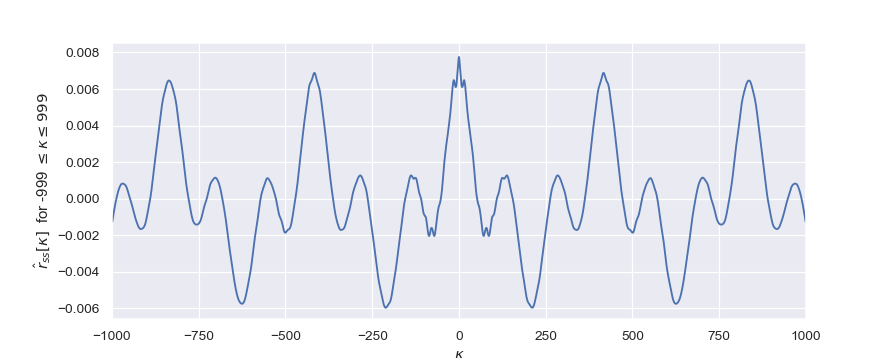

In [6]:
K=1000

# compute and truncate ACF
acf = 1/len(s) * np.correlate(s, s, mode='full')
acf = acf[(len(s)-1)-(K-1):(len(s)-1)+K]
kappa = np.arange(-(K-1), K)
print(str(np.min(kappa)) + ' <= kappa <= ' + str(np.max(kappa)) )

# plot signal and its ACF
plt.figure(figsize=(10, 4))
#plt.stem(x[:4*K], basefmt='C0:', use_line_collection=True)
plt.plot(s[:4*K])
plt.xlim(0, 4*K)
plt.xlabel('$k$')
plt.ylabel('$s[k]$ for the first $2K='+str(4*K)+'$ samples')
plt.grid(True)

plt.figure(figsize=(10, 4))
#plt.stem(kappa, acf, basefmt='C0:', use_line_collection=True)
plt.plot(kappa, acf)
plt.xlabel('$\kappa$')
plt.ylabel('$\hat{r}_{ss}[\kappa]$  for ' + str(np.min(kappa)) + ' $\leq \kappa \leq ' + str(np.max(kappa)) + '$')
plt.axis([-K, K, 1.1*min(acf), 1.1*max(acf)])
plt.grid(True)

## Fundamental Frequency Estimation

With the knowledge of the ACF we will now extract the fundamental frequency $f_0$ of a speech signal which is a.k.a. pitch frequency and is the frequency exitation of the speech production system, i.e. after the [vocal cords](https://en.wikipedia.org/wiki/Vocal_cords).

To determine $f_0$ we first calculate the autocorrelation estimate $\hat{r}_{xx}[\kappa]$ of the signal and then look for the highest correlation value. To determine the periodicity of the signal we are interested in the distance of the ACF maxima. Since we know that we always have a maximum at $\kappa=0$ we are interested in identifying the second main maximum.

To be more robust in case of mixed (voiced/unvoiced) excitation  signals, we only look in the time shift range which corresponds to likely frequencies for human voice. Typical pitch frequencies for humans are in an range between $f_{min}=50$ Hz and $f_{max}=500$ Hz. With the knowledge that discrete time variables $\kappa$ are related to discrete frequency variables by the sampling frequency $f_s$ we can calculate the *search area* (orange shaded below) between $\kappa_{\mathrm{max}} = \operatorname{round}\left(\frac{f_s}{f_{\mathrm{max}}}\right)$ and $\kappa_{\mathrm{min}} = \operatorname{round}\left(\frac{f_s}{f_{\mathrm{min}}}\right)$.

Between those two values we find the time-shift $\kappa_0$ of the maximal value which gives us the corresponding frequency $f_0 = \frac{f_s}{\kappa_0}$.

The relation is also shown in the following figure where we see some autocorrelation sequence and observe how $f_{min}$ and $f_{max}$ constrain the search space for the highest autocorrelation value.

<img src="autocorrelation_frequencies.svg" align="center"/>
<center><span style="font-size:smaller">
    <b>Fig. 1:</b> Autocorrelation sequence with <i>search area</i> in ornage and identified main peak $\kappa_0, \kappa_0>0$ in green.
</span></center>

Note that the absolute numbers in the figure above are only valid if the sampling frequency $f_s$ matches. The formulas, however, are generally applicable.

Length of ACF:    1999
ACF center index: 999
kappa_min:        1087
kappa_max:        1881
maximum at sample 1416, i.e. 417 samples from \kappa=0.
pitch frequency f_0 is 105.75539568345324 Hz


<IPython.core.display.Javascript object>


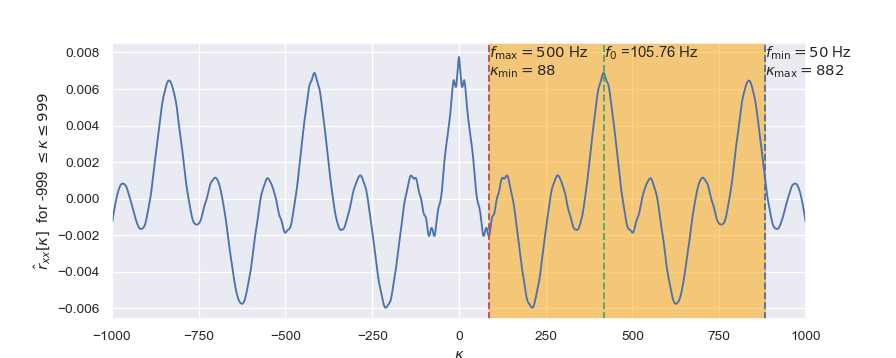

In [7]:
f_min_hz=50    # lower frequency in Hz defining our search range
f_max_hz=500   # upper frequency in Hz defining our search range

# The minimal and maximal shift (in samples) we want to look at is calculated from the frequency boundaries
kappa_acf_center=len(acf)//2
kappa_min = kappa_acf_center + int(np.round(fs / f_max_hz))
kappa_max = kappa_acf_center + int(np.round(fs / f_min_hz))

print('Length of ACF:    '+str(len(acf)))
print('ACF center index: '+str(kappa_acf_center))
print('kappa_min:        '+str(kappa_min))
print('kappa_max:        '+str(kappa_max))

# find the maximum value of the ACF (in the search range)
max_correlation_kappa = kappa_min + np.argmax(acf[kappa_min : kappa_max + 1])

# calculate pitch frequency
f_p=fs/(max_correlation_kappa-kappa_acf_center)

print('maximum at sample '+str(max_correlation_kappa)+', i.e. '+
      str(max_correlation_kappa-kappa_acf_center)+' samples from \kappa=0.')
print('pitch frequency f_0 is '+str(f_p)+' Hz')


plt.figure(figsize=(10, 4))
#plt.stem(kappa, acf, basefmt='C0:', use_line_collection=True)
plt.plot(kappa, acf)
plt.xlabel('$\kappa$')
plt.ylabel('$\hat{r}_{xx}[\kappa]$  for ' + str(np.min(kappa)) + ' $\leq \kappa \leq ' + str(np.max(kappa)) + '$')
plt.axis([-K, K, 1.1*min(acf), 1.1*max(acf)])

# add a shaded area illustrating the "search range"
plt.axvspan(kappa_min-kappa_acf_center,kappa_max-kappa_acf_center, alpha=0.5, color='orange')

# add vertical lines to the plot to visualise found values
plt.axvline(kappa_min-kappa_acf_center, color='r', ls='--')
plt.axvline(kappa_max-kappa_acf_center, color='b', ls='--')
plt.axvline(max_correlation_kappa-kappa_acf_center, color='g', ls='--')

# add some annotation
plt.text(kappa_min-kappa_acf_center,np.max(acf),
         '$f_{\mathrm{max}}='+str(f_max_hz)+'$ Hz')
plt.text(kappa_max-kappa_acf_center,np.max(acf),
         '$f_{\mathrm{min}}='+str(f_min_hz)+'$ Hz')
plt.text(kappa_min-kappa_acf_center,np.max(acf)-0.001,
         '$\kappa_{\mathrm{min}}='+str(kappa_min-kappa_acf_center)+'$')
plt.text(kappa_max-kappa_acf_center,np.max(acf)-0.001,
         '$\kappa_{\mathrm{max}}='+str(kappa_max-kappa_acf_center)+'$')
plt.text(max_correlation_kappa-kappa_acf_center,np.max(acf),
         '$f_0$ =%.2f Hz' % f_p)
plt.grid(True)

## Generation of Glottal Exitation Signal (Task 5)

A single glottal impulse is shown in [Fig. 2](#SpeechGenerationGlottalImpulse) exemplarily for a sampling frequency of $f_s=8 \,\mathrm{kHz}$ and a pitch frequency of $f_p = 150 \,\mathrm{Hz}$, i.e. the signal part shown in [Fig. 2](#SpeechGenerationGlottalImpulse) would be repeated $150$ times per second.

<img id='SpeechGenerationGlottalImpulse' src="SpeechGenerationGlottalImpulse.svg" align="center" width="700px">
<center><span style="font-size:smaller">
    <b>Fig. 2:</b> Single glottal impulse.
</span></center>

We call the length of the impulse in seconds $T_0=\frac{1}{f_p}$, and the length in samples can be determined by

\begin{equation}
L_g = \left\lfloor \frac{f_s}{f_p} \right\rfloor 
\label{eq:glottalImpulseLength}\tag{4}
\end{equation}

with the operator $\lfloor \cdot \rfloor$ in (\ref{eq:glottalImpulseLength}) being the flooring operator, implemented in `Python` as `np.floor()`. For the chosen example of $f_p = 150 \,\mathrm{Hz}$ and $f_s=8 \,\mathrm{kHz}$, the impulse length in seconds is $T_0=\frac{1}{f_p}=6.\bar{6} \,\mathrm{ms}$ and the length in samples is $L_g = \left\lfloor \frac{8,000 \,\mathrm{Hz}}{150 \,\mathrm{Hz}} \right\rfloor  = 53$, as it also can be seen in [Fig. 2](#SpeechGenerationGlottalImpulse). 

This pulse can be decomposed in three parts [[Fan79]](https://www.speech.kth.se/prod/publications/files/qpsr/1979/1979_20_1_085-107.pdf),
* (i) an *attack* part, i.e. the time of the raising branch, for time $t$ ranging from $0$ seconds to the time of the peak (maximum) $t_{\mathrm{peak}}$, which is a parameter we can choose and which was chosen in the example in [Fig. 2](#SpeechGenerationGlottalImpulse) to be approx $35 \%$ of the overall length, i.e. $t_{\mathrm{peak}}= 35 \% \cdot T_0$, or in samples $L_{\mathrm{attack}}=\left\lfloor 35 \% \cdot L_g \right\rceil$ with the operator $\left\lfloor \cdot \right\rceil$, being the rounding operator, implemented in `Python` as `np.round()`,
* (ii) a *decay* or *release* part, i.e. the descending branch, for time $t$ ranging from $t_{\mathrm{peak}}$ to $t_c$, and 
* (iii) a *sustain* part, i.e. a period without change, here of silence (zeros),

\begin{equation}
g(t) = 
\left\{
\begin{array}{lll}
g_{\mathrm{attack}}(t)  & \text{for } 0<t<t_{\mathrm{peak}},      & \text{the attack or rising branch,} \\
g_{\mathrm{release}}(t) & \text{for } t_{\mathrm{peak}}< t < t_c, & \text{the decay or or release or descending branch,} \\
g_{\mathrm{sustain}}(t) & \text{for } t_c < t < T_0,              & \text{the sustain or zero part,}
\end{array}
\right.
\label{eq:glottalImpulseSchematic}\tag{5}
\end{equation}

Following [[Fan79]](https://www.speech.kth.se/prod/publications/files/qpsr/1979/1979_20_1_085-107.pdf), the time $t_c$ can be calculated by

\begin{equation}
t_c=t_{\mathrm{peak}}+\frac{\mathrm{arcos}\left(\frac{K-1}{K}\right)}{\omega_g},
\label{eq:DecayReleaseTime} \tag{6}
\end{equation}

with $K$ being another paprameter influencing the steepness of the decaying part. For $K=0.5$, the impulse is symetric and a typical value might be $K=2$. Defining the three parts of the glottal impluse mathematically leads to [[Fan79]](https://www.speech.kth.se/prod/publications/files/qpsr/1979/1979_20_1_085-107.pdf)

\begin{equation}
g(t) = 
\left\{
\begin{array}{ll}
\frac{1}{2}(1-\mathrm{cos}(\omega_g t)) &  \text{for } 0<t<t_{\mathrm{peak}}, \\
K \cdot \mathrm{cos}(\omega_g(t-t_{\mathrm{peak}}))-K+ 1 & \text{for } t_{\mathrm{peak}}< t < t_c,  \\
0 & \text{for } t_c < t < T_0,
\end{array}
\right.
\label{eq:glottalImpulse}\tag{7}
\end{equation}

The angular frequency needed in (\ref{eq:DecayReleaseTime}) and (\ref{eq:glottalImpulse}) can be defined as $\omega_g = \pi/t_{\mathrm{peak}}$.

Let's create the glottal pulse in (\ref{eq:glottalImpulse}) step by step, revising some exercises implemented before. For this, let's focus on the first part, the *raising* branch first which is nothing else than a raised cosine. 

\begin{equation}
g_{\mathrm{attack}}(t) =
\frac{1}{2}(1-\mathrm{cos}(\omega_g t)) \quad \text{if } 0<t<t_{\mathrm{peak}}
\end{equation}

To achieve this step-by-step we first creare a well know cosine signal $x_1(t_1) = \cos(\omega_g t_1)$ for a whole period, i.e. for times $0 \leq t_1 \leq L_g/f_s$. As a second step we create a *raised cosine*, i.e. $x_2(t_1) = 0.5 \dot (1-\cos(\omega_g t_1))$. With this we can now simply truncate the time vector to times $0 \leq t \leq t_{\mathrm{peak}}$, reaslising that $t_{\mathrm{peak}} = L_{\mathrm{attack}} / f_s$.

A period of a signal with frequency of 150 Hz is 0.006666666666666667 seconds or 53.333333333333336 samples
The glottis impulse has thus a length of 53.0


<IPython.core.display.Javascript object>


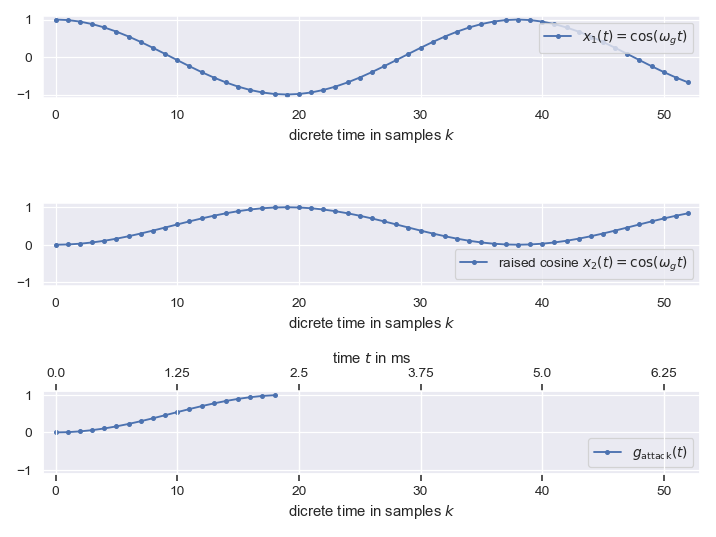

In [8]:
# reminder (lab-sheet 1), generation of a sine signal
fs = 8000                          # samples per second
dt = 1/fs                          # seconds per sample

fp = 150                           # pitch frequency (of complete glottis pulse)
Lg = np.floor(fs/fp)               # number of samples per glottis pulse
Lattack = np.round(0.35*Lg)        # length of the attach part
tPeak = Lattack / fs               # time in seconds of the attack part

print('A period of a signal with frequency of '+str(fp)+' Hz is '+str(1/fp)+' seconds or '+str(fs/fp)+' samples')
print('The glottis impulse has thus a length of '+str(Lg))

omega_g = np.pi / tPeak            # (angular) frequency

# let's first create a full period of the sinus (since we know how this works)
t1 = np.arange(0,Lg/fs,dt)         # time vector in seconds (one period length)
x1 = np.cos(omega_g*t1)            # one period of cosine wave signal

# now a raised cosine
x2 = 0.5*(1-np.cos(omega_g*t1))    # rased cosine signal (same time vector as before)

# sine signal of frequency fp Hz
tAttack = np.arange(0,tPeak,dt)         # shorter time vector in seconds
gAttack = 0.5*(1-np.cos(omega_g*tAttack))     # same raised cosine signal as before for shorter time

plt.figure(figsize=(8,6))
plt.subplot(3,1,1)
plt.plot(x1,marker='.',label='$x_1(t)=\cos(\omega_g t)$')
plt.xlim(-1,Lg)
plt.ylim(-1.1,1.1)
plt.xlabel('dicrete time in samples $k$')
plt.legend(loc='upper right')

plt.subplot(3,1,2)
plt.plot(x2,marker='.',label='raised cosine $x_2(t)=\cos(\omega_g t)$')
plt.xlim(-1,Lg)
plt.ylim(-1.1,1.1)
plt.xlabel('dicrete time in samples $k$')
plt.legend(loc='lower right')

plt.subplot(3,1,3)
plt.plot(gAttack,marker='.',label='$g_{\mathrm{attack}}(t)$')
plt.xlim(-1,Lg)
plt.ylim(-1.1,1.1)
plt.xlabel('dicrete time in samples $k$')
plt.legend(loc='lower right')

# create a second axis to (additionally) show time in ms
ax1 = plt.gca()                   # get current axis
ax2 = ax1.twiny()                 # add a secod axis (allowing for second x-labels) 
ax2.set_xticks(ax1.get_xticks())  # copy x-ticks to second axis
ax2.set_xbound(ax1.get_xbound())  # copy x-bounds to second axis
ax2.set_xticklabels([str(x/fs*1000) for x in ax1.get_xticks()])
ax2.set_xlabel('time $t$ in ms');

plt.tight_layout()


Let's now focus on the *descending branch* of the glottal impulse.

0.5
1.0471975511965979
tPeak=2.375 ms, 19.0samples
tc=   3.1666666666666665 ms, 25.333333333333332samples


<IPython.core.display.Javascript object>


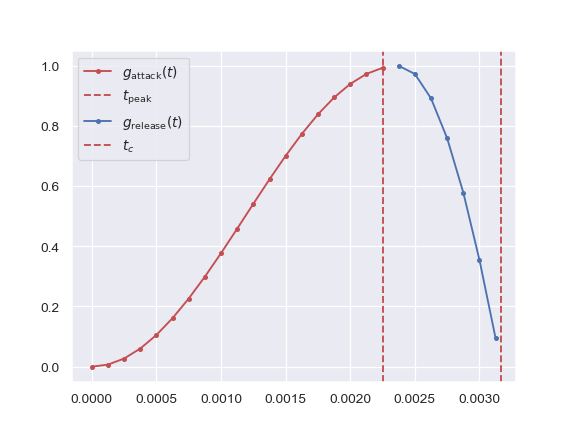

In [9]:
K=2

Ldecay = np.round(0.15*Lg)        # length of the attach part
print((K-1)/K)
print(np.arccos((K-1)/K))
      
      
tc = tPeak + np.arccos((K-1)/K)/omega_g

print('tPeak='+str(tPeak*1000)+' ms, '+str(tPeak*fs)+'samples')
print('tc=   '+str(tc*1000)+' ms, '+str(tc*fs)+'samples')

t = np.arange(tPeak,tc,dt)         # shorter time vector in seconds

g_decay= K* np.cos(omega_g * (t-tPeak)) -K +1

plt.figure()
plt.plot(tAttack,gAttack,marker='.',c='r',label='$g_{\mathrm{attack}}(t)$')
plt.axvline(x=np.max(tAttack),c='r',ls='--',label='$t_\mathrm{peak}}$')
plt.plot(t,g_decay,marker='.',label='$g_{\mathrm{release}}(t)$')
plt.axvline(x=np.max(tc),c='r',ls='--',label='$t_c$')

plt.legend();

By appending zeros as the *sustain part*, we can now create the complete glottal impulse.

<IPython.core.display.Javascript object>


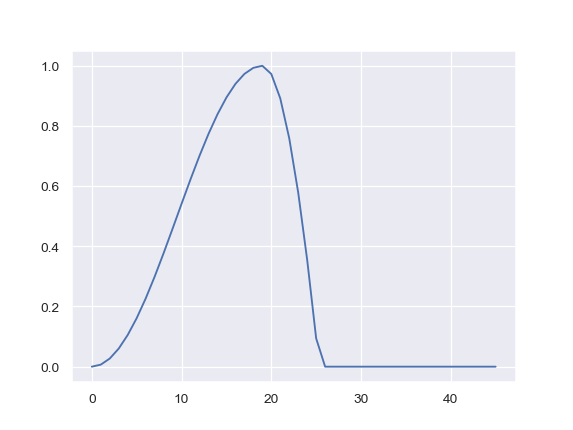

In [10]:
g=np.concatenate((gAttack,g_decay,np.zeros(20,)))

plt.figure()
plt.plot(g);

## Copyright

This notebook is licensed under [Creative Commons Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) to be used during the lecture COM[3502](http://www.dcs.shef.ac.uk/intranet/teaching/public/modules/level3/com3502.html "Open web page for COM3502 module")-[4502](http://www.dcs.shef.ac.uk/intranet/teaching/public/modules/level4/com4502.html "Open web page for COM4502 module")-[6502](http://www.dcs.shef.ac.uk/intranet/teaching/public/modules/msc/com6502.html "Open web page for COM4502 module") Speech Processing at the [University of Sheffield](https://www.sheffield.ac.uk/ "Open web page of The University of Sheffield"), Dept. of [Computer Science](https://www.sheffield.ac.uk/dcs "Open web page of Department of Computer Science, University of Sheffield"). You may download, [clone](https://docs.github.com/en/repositories/creating-and-managing-repositories/cloning-a-repository) or [fork](https://docs.github.com/en/get-started/quickstart/fork-a-repo) it to your computer or private [GitHub](https://github.com/) account. 

### References

[[Fan79]](https://www.speech.kth.se/prod/publications/files/qpsr/1979/1979_20_1_085-107.pdf) G. Fant. Vocal source analysis - a progress report. STL-QPSR, 20(3-4):31–53, 1979 

### Contributors
[Stefan Goetze](http://www.stefan-goetze.de "Web page of Stefan Goetze"),
[Lena Strobl](https://github.com/sleyna/)